In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import collections
import numpy as np

In [98]:
df = pd.read_csv('results/sim_trace.csv')

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              54 non-null     int64  
 1   type            54 non-null     object 
 2   app             54 non-null     int64  
 3   module          54 non-null     object 
 4   message         54 non-null     object 
 5   DES.src         54 non-null     int64  
 6   DES.dst         54 non-null     int64  
 7   TOPO.src        54 non-null     int64  
 8   TOPO.dst        54 non-null     int64  
 9   module.src      54 non-null     object 
 10  service         54 non-null     float64
 11  time_in         54 non-null     float64
 12  time_out        54 non-null     float64
 13  time_emit       54 non-null     float64
 14  time_reception  54 non-null     float64
dtypes: float64(5), int64(6), object(4)
memory usage: 6.5+ KB


In [100]:
df["time_latency"] = df["time_reception"] - df["time_emit"]
df["time_wait"] = df["time_in"] - df["time_reception"]  
df["time_service"] = df["time_out"] - df["time_in"]
df["time_response"] = df["time_out"] - df["time_reception"]
df["time_total_response"] = df["time_response"] + df["time_latency"]

In [101]:
# convert index to date type in order to use resample and agreegate functions of pandas
df["date"]=df.time_in.astype('datetime64[s]')
df.index = df.date

In [102]:
df.head()

,id,type,app,module,message,DES.src,DES.dst,TOPO.src,TOPO.dst,module.src,...,time_in,time_out,time_emit,time_reception,time_latency,time_wait,time_service,time_response,time_total_response,date
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:01:41,1,COMP_M,0,0_01,M.USER.APP.0,0,6,1,0,None,...,101.00002,101.10002,100.0,101.00002,1.00002,0.0,0.1,0.1,1.10002,1970-01-01 00:01:41
1970-01-01 00:01:41,2,COMP_M,1,1_01,M.USER.APP.1,1,7,2,0,None,...,101.00002,101.10002,100.0,101.00002,1.00002,0.0,0.1,0.1,1.10002,1970-01-01 00:01:41
1970-01-01 00:01:41,4,COMP_M,3,3_01,M.USER.APP.3,3,9,4,0,None,...,101.00002,101.10002,100.0,101.00002,1.00002,0.0,0.1,0.1,1.10002,1970-01-01 00:01:41
1970-01-01 00:01:42,3,COMP_M,2,2_01,M.USER.APP.2,2,8,3,0,None,...,102.00004,102.10004,100.0,102.00004,2.00004,0.0,0.1,0.1,2.10004,1970-01-01 00:01:42
1970-01-01 00:01:42,5,COMP_M,4,4_01,M.USER.APP.4,4,10,5,0,None,...,102.00004,102.10004,100.0,102.00004,2.00004,0.0,0.1,0.1,2.10004,1970-01-01 00:01:42


In [103]:
df_resample = df.resample('100s').agg(dict(time_latency='mean'))

In [104]:
df_resample.shape

(9, 1)

In [105]:
timeLatency = df_resample.time_latency.values

In [106]:
ticks = range(len(timeLatency))

Text(0, 0.5, 'Latency time')

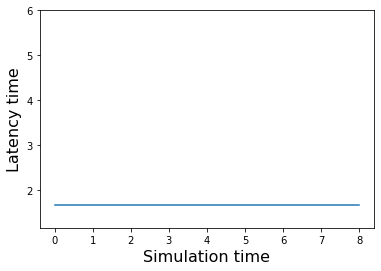

In [107]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(ticks, timeLatency, '-')
ax1.set_ylim(timeLatency.min()-0.5,6)#timeLatency.max()+0.5)
ax1.set_xlabel("Simulation time", fontsize=16)
ax1.set_ylabel("Latency time", fontsize=16)

# Latency

In [108]:
df_resample = df.resample('100s').agg(dict(time_latency='mean'))

In [109]:
df_resample.shape

(9, 1)

In [110]:
timeLatency = df_resample.time_latency.values

In [111]:
ticks = range(len(timeLatency))

Text(0, 0.5, 'Latency time')

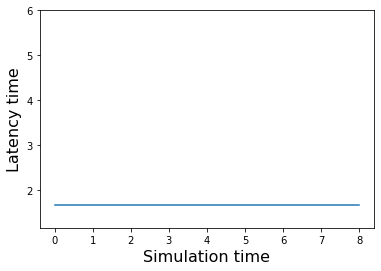

In [112]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(ticks, timeLatency, '-')
ax1.set_ylim(timeLatency.min()-0.5,6)#timeLatency.max()+0.5)
ax1.set_xlabel("Simulation time", fontsize=16)
ax1.set_ylabel("Latency time", fontsize=16)

# Hop Count

In [113]:
# Hop count
cache_distance = {}

In [114]:
G = nx.read_graphml('results/graph_binomial_tree_3.graphml')

In [115]:
print(G.nodes())

['0', '1', '2', '3', '4', '5', '6', '7']


In [116]:
def compute_distance(k):
    return nx.shortest_path_length(G,str(k[0]),str(k[1]))

In [117]:
for row in df[["TOPO.src","TOPO.dst"]].iterrows():
    k = (row[1][0],row[1][1])
    if not k in cache_distance.keys():
        cache_distance[k] = compute_distance(k)

In [118]:
x = cache_distance.values() 
counter = collections.Counter(x)
print(counter)

Counter({1: 3, 2: 3})


In [119]:
data_a = {}
for k in range(8):
    data_a[k] = counter[k]

In [120]:
data_a

{0: 0, 1: 3, 2: 3, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}

In [121]:
data_a = data_a.values()

In [122]:
ticks = range(8)

In [123]:
N = len(ticks)
ind = np.array(ticks)
width = 0.45

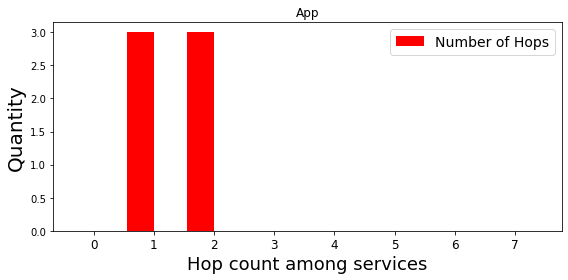

In [133]:
fig, ax = plt.subplots(figsize=(8.0,4.0))
ax.get_xaxis().set_ticks(range(0, len(ticks) * 2, 2))
r = ax.bar(ind, data_a, width, color='r')
ax.set_xticks(ind+ width/2)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_title("App")
ax.set_xlim(-width, len(ticks))
ax.plot([], c='#a6bddb', label="No LABEL",linewidth=3)
ax.set_xlabel("Hop count among services", fontsize=18)
ax.set_ylabel("Quantity", fontsize=20)
plt.legend([r],['Number of Hops'],loc="upper right",fontsize=14)
plt.tight_layout()

In [125]:
df_link = pd.read_csv('results/sim_trace_link.csv')

In [132]:
df_link.head(10)

,id,type,src,dst,app,latency,message,ctime,size,buffer
0,1,LINK,1,0,0,1.00002,M.USER.APP.0,100.00000,20,0
1,2,LINK,2,0,1,1.00002,M.USER.APP.1,100.00000,20,1
2,3,LINK,3,2,2,1.00002,M.USER.APP.2,100.00000,20,2
3,4,LINK,4,0,3,1.00002,M.USER.APP.3,100.00000,20,3
4,5,LINK,5,4,4,1.00002,M.USER.APP.4,100.00000,20,4
5,6,LINK,6,4,5,1.00002,M.USER.APP.5,100.00000,20,5
6,3,LINK,2,0,2,1.00002,M.USER.APP.2,101.00002,20,0
7,5,LINK,4,0,4,1.00002,M.USER.APP.4,101.00002,20,1
8,6,LINK,4,0,5,1.00002,M.USER.APP.5,101.00002,20,2
9,7,LINK,1,0,0,1.00002,M.USER.APP.0,200.00000,20,0


In [127]:
total_messages = len(df_link)
print(f'total messages transmited = {total_messages}')

total messages transmited = 81


In [128]:
bytes_transmited = df_link["size"].sum()
print(f'total bytes transmited = {bytes_transmited}')

total bytes transmited = 1620


In [129]:
new_dlink = df_link[(df_link.id == 3)]


In [130]:
new_dlink

,id,type,src,dst,app,latency,message,ctime,size,buffer
2,3,LINK,3,2,2,1.00002,M.USER.APP.2,100.00000,20,2
6,3,LINK,2,0,2,1.00002,M.USER.APP.2,101.00002,20,0
